In [1]:
import tensorflow as tf

In [9]:
x = tf.constant(1.0)
w1 = tf.constant(2.0)
b1 = tf.constant(1.0)
w2 = tf.constant(2.0)
b2 = tf.constant(1.0)

with tf.GradientTape(persistent=True) as tape:
    #persistent=True用于多此求取梯度，因为默认情况下GradientTape的资源在调用gradient函数后就被释放，再次调用就无法计算了
    tape.watch([w1, b1, w2, b2])
    
    o1 = x * w1 + b1
    o2 = o1 * w2 + b2

do2_do1 = tape.gradient(o2, [o1])[0]
do1_dw1 = tape.gradient(o1, [w1])[0]
do2_dw1 = tape.gradient(o2, [w1])[0]


print(do2_do1 * do1_dw1)
print(do2_dw1)

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [ ]:
# 模拟  函数  f(x, y) = (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [10]:
# 定义函数
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

In [12]:
# 数据生成
import numpy as np

x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
print(x.shape, y.shape)

(120,) (120,)


In [13]:
x, y = np.meshgrid(x, y)
print(x.shape, y.shape)

(120, 120) (120, 120)


In [15]:
# 计算z值
z = himmelblau([x, y])
print(z.shape)

(120, 120)


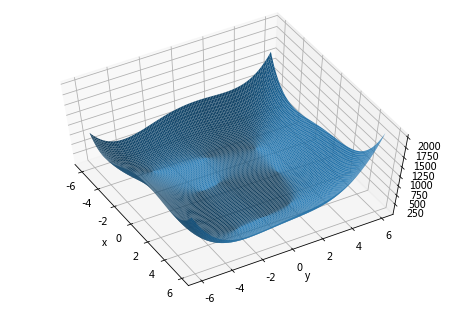

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure('himmelblau')
ax = Axes3D(fig)
ax.plot_surface(x, y, z, rstride=1,cstride=1)
ax.view_init(60, -30)
# view_init: 将曲面旋转，该函数有两个参数，分别是elev和azim，第一个参数指从哪个高度查看曲面，第二个参数指旋转的角度
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

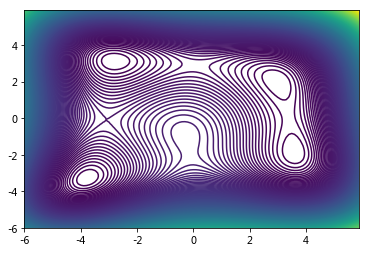

In [26]:
# 画函数等高线
## ??, 和书上的等高线不相同

# plt.contourf(x,y,z,50)
plt.contour(x,y,z,300)
plt.show()

In [33]:
# 利用梯度下降策略，求取函数最小值点
# 初始化
import tensorflow as tf

x = tf.constant([-4., 0.])

for i in range(200):
    with tf.GradientTape() as tape:
        tape.watch([x])
        o = himmelblau(x)
    grads = tape.gradient(o, [x])[0]
    x = x - 0.01 * grads
    
    if i % 20 == 0:
        print('steps {}, x {} and y {}'.format(i, x.numpy(), o.numpy()))

steps 0, x [-2.98       -0.09999999] and y 146.0
steps 20, x [-3.6890156 -3.1276684] and y 6.054738998413086
steps 40, x [-3.7793102 -3.283186 ] and y 0.0
steps 60, x [-3.7793102 -3.283186 ] and y 0.0
steps 80, x [-3.7793102 -3.283186 ] and y 0.0
steps 100, x [-3.7793102 -3.283186 ] and y 0.0
steps 120, x [-3.7793102 -3.283186 ] and y 0.0
steps 140, x [-3.7793102 -3.283186 ] and y 0.0
steps 160, x [-3.7793102 -3.283186 ] and y 0.0
steps 180, x [-3.7793102 -3.283186 ] and y 0.0


## 手动构建神经网络

In [3]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [41]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set 

In [4]:
# 数据生成
n_samples = 2000
test_size = 0.3
X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1400, 2) (600, 2) (1400,) (600,)


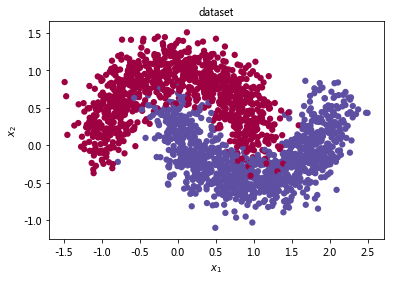

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
plt.title('dataset', fontsize=10)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [39]:
# 创建Layer层
class Layer:
    def __init__(self, n_inputs, units, activation=None, weights = None, bias = None):
        #n_inputs: 输入元素个数
        self.weights = weights if weights is not None else np.random.randn(n_inputs, units) / np.sqrt(1/units)#这个过程为什么需要除以输出节点数量倒数的开平发，没有想明白
        self.bias = bias if bias is not None else np.random.rand(units) * 0.1 # 这边的初始化对原始生成的随机值还乘了0.1，理由是什么
        
        self.activation = activation
        self.last_activation = None #激活函数的输出
        self.error = None #用于计算梯度
        self.delta = None
    
    def activate(self, inputs):
        z = inputs@self.weights + self.bias
        self.last_activation = self._apply_activation(z)
        return self.last_activation
    
    def _apply_activation(self, z):
        # 基于激活函数类型，对输出进行计算
        if self.activation is None:#线性激活
            return z
        elif self.activation == 'relu':
            return np.maximum(z, 0)
        elif self.activation == 'sigmoid':
            return 1/(1+np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z#防止其他意外输入
        
    def de_activate(self, z):
        # 根据不同的激活函数计算当前层的delta,用于反向传播
        if self.activation is None:
            return np.ones_like(z)# 没有激活函数，导数为1
        elif self.activation == 'relu':
            grads = np.array(z, copy=True)
            grads[z>0]=1
            grads[z<=0]=0
            return grads
        elif self.activation == 'sigmoid':
            return z * (1-z)
        elif self.activation =='tanh':
            return 1-r**2
        else:
            return np.ones_like(z)

In [44]:
# 定义model
class Network:
    def __init__(self):
        self._layers = []
    
    def add_layer(self, layer):
        self._layers.append(layer)
        
    def forword(self, x):
        # 前向传播
        for layer in self._layers:
            x = layer.activate(x)
        return x
    
    def backword(self, x, y, lr):
        # 定义反向传播过程
        output = self.forword(x)
        # 反向传播，从最后一层开始计算梯度，然后利用链式法则层层计算
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]# 获取当前层
            
            #最后一层的梯度计算方式不一样
            if layer == self._layers[-1]:
                layer.error = output - y   #公式中是 ok-tk
                layer.delta = layer.error * layer.de_activate(output)
            else:
                next_layer = self._layers[i+1]#下一层，链式法则
                layer.error =  np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.de_activate(layer.last_activation)
        
        # 根据每一层的delta进行权值更新
        for i in range(len(self._layers)):
            layer = self._layers[i]
            #如果是第一层，则直接是输入元素x
            # 否则是上一层的激活输出
            o_i = np.atleast_2d(x if i==0 else self._layers[i-1].last_activation)
            layer.weights -= layer.delta * o_i.T * lr #代码中计算的是-delta，所以这边是+=

In [45]:
nn = Network()

In [46]:
nn.add_layer(Layer(2, 25, 'sigmoid'))
nn.add_layer(Layer(25, 50, 'sigmoid'))
nn.add_layer(Layer(50, 25, 'sigmoid'))
nn.add_layer(Layer(25, 2, 'sigmoid'))

In [47]:
# 网络训练过程
y_onehot = np.zeros((y_train.shape[0], 2))
y_onehot[np.arange(y_train.shape[0]), y_train] = 1
mses = [] #误差存储
for i in range(1000):
    for j in range(len(X_train)):
        nn.backword(X_train[j], y_onehot[j], lr = 0.01)
    if i % 10 ==0:
        mse = np.mean(np.square(y_onehot - nn.forword(X_train)))
        mses.append(mse)
        
        print('epoch: #%s, mse: %f'%(i, float(mse)))
        y_test_out = nn.forword(X_test)
        y_test_label = np.argmax(y_test_out, axis=1)
        accuracy_count = np.sum(np.equal(y_test_label, y_test))
        print('accuracy: %.2f %%' % (float(accuracy_count) / len(y_test) * 100))

epoch: #0, mse: 0.151494
accuracy: 87.83 %
epoch: #10, mse: 0.043564
accuracy: 95.67 %
epoch: #20, mse: 0.033649
accuracy: 96.67 %
epoch: #30, mse: 0.030381
accuracy: 96.33 %
epoch: #40, mse: 0.028636
accuracy: 96.67 %
epoch: #50, mse: 0.027400
accuracy: 96.67 %
epoch: #60, mse: 0.026422
accuracy: 96.67 %
epoch: #70, mse: 0.025735
accuracy: 96.83 %
epoch: #80, mse: 0.025205
accuracy: 97.00 %
epoch: #90, mse: 0.024769
accuracy: 97.17 %
epoch: #100, mse: 0.024397
accuracy: 97.00 %
epoch: #110, mse: 0.024078
accuracy: 97.00 %
epoch: #120, mse: 0.023813
accuracy: 97.00 %
epoch: #130, mse: 0.023590
accuracy: 97.00 %
epoch: #140, mse: 0.023390
accuracy: 97.00 %
epoch: #150, mse: 0.023200
accuracy: 97.00 %
epoch: #160, mse: 0.023014
accuracy: 97.00 %
epoch: #170, mse: 0.022832
accuracy: 97.17 %
epoch: #180, mse: 0.022654
accuracy: 97.17 %
epoch: #190, mse: 0.022474
accuracy: 97.50 %
epoch: #200, mse: 0.022266
accuracy: 97.50 %
epoch: #210, mse: 0.022055
accuracy: 97.50 %
epoch: #220, mse: 0.0